This notebook first calibrates $\pi/2$ pulse and use the calibrated amplitude to create pulse using schedular. `CmdDef` is replaced with created gaussian pulse. Randomized Benchmarking is demonstrated with pulse.

## Import libraries and classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Import Qiskit classes classes
import qiskit

from qiskit import IBMQ
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_library
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.compiler import assemble
from qiskit.scheduler import schedule

#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

## Load Backend

In [2]:
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider(hub='provide_your_hub_here', group='provide_your_group_here', 
                                  project='provide_your_project_here')

backend = ibmq_provider.get_backend('provide_your_device_name_here')

In [9]:
defaults = backend.defaults()
default = defaults.buffer
config = backend.configuration()

In [10]:
system = pulse.PulseChannelSpec.from_backend(backend)

## Calibrate $\pi/2$ pulse with measurement level-2

Use calibrated pulses provided by backend via `CmdDef`.

In [11]:
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

measure = cmd_def.get('measure', qubits=config.meas_map[0])

Specify experiment configuration and pulse parameters. We create a gently‐sloping gaussian pulse. 

In [7]:
# qubit to use for experiment
qubit = 0

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 0.05, exps)
drive_samples = 170
drive_sigma = 30

# scaling factor for data returned by system
scale_factor=1e-10

In [124]:
# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_library.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(system.qubits[qubit].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

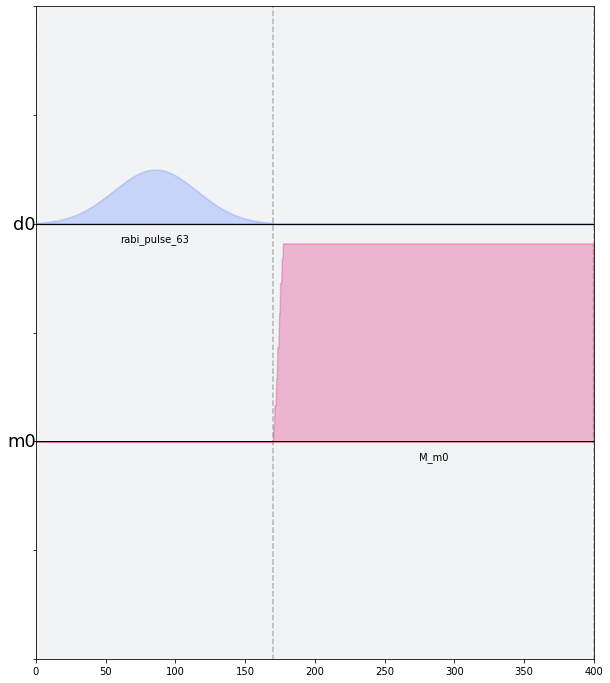

In [125]:
schedules[-1].draw(channels_to_plot=[system.qubits[qubit].measure, system.qubits[qubit].drive],
                   scaling=10.0, label=True, plot_range=(0, 400))

In [126]:
rabi_qobj = assemble(schedules, backend, meas_level=2, shots=shots)

In [ ]:
job = backend.run(rabi_qobj)

In [ ]:
job.job_id()

In [9]:
rabi_result = job.result(timeout=3600)

### Get result

In [10]:
data = []
for i in range(exps):
    rabi_data = list(rabi_result.get_counts(i).keys())
    data.append(rabi_data)

Get qubit0 result

In [11]:
results = []
for i in range(len(data)): 
    rabi_data = data[i]
    
    rabi_results = []
    for j in range(len(data[i])): 
        # Specify qubit 0
        rabi_result = rabi_data[j][::-1][0]
        rabi_results.append(rabi_result)
        
    results.append(rabi_results)

Convert data in string into integer values.

In [12]:
int_qstates = []
for i in range(len(results)):
    qstate_result = results[i]
    
    int_qstate = []
    for j in range(len(results[i])):
        qstate = int(qstate_result[j])
        int_qstate.append(qstate)
    
    int_qstates.append(int_qstate)

Convert quantum states into <$\sigma_z$> expectation values.

In [13]:
expect_vals = []
for i in range(len(int_qstates)):
    expect_val = np.array([1 if qstate == 0 else -1 for qstate in int_qstates[i]])
    expect_vals.append(expect_val)

In [14]:
mean_expvals = []
for expect_val in expect_vals:
    mean_expval = np.mean(expect_val)
    mean_expvals.append(mean_expval)

half pi amplitude 0.005378


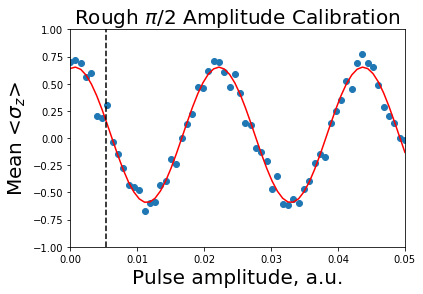

In [17]:
fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, mean_expvals, [0.75,0.0,0.023,0])

#get the pi amplitude
half_pi_amp = fitparams[2]/4

plt.scatter(drive_amps, mean_expvals)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(half_pi_amp, color='black', linestyle='dashed')
plt.xlim(drive_amps[0], drive_amps[-1])
plt.ylim(-1, 1)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20);
plt.ylabel('Mean <$\sigma_z$>', fontsize=20);
plt.title('Rough $\pi/2$ Amplitude Calibration', fontsize=20)

print('half pi amplitude %f'%(half_pi_amp))

## Rewrite cmd_def

In [6]:
def replace_cmd(cmd_def, name, qubits, replaced_pulses):

    def create_fc_sched(channel, t0, pname):
        def gen_fc(**kwargs):
            phase = list(kwargs.values())[0]
            return pulse.commands.FrameChange(-phase)(channel) << t0
    
        return pulse.schedule.ParameterizedSchedule(gen_fc, parameters=pname)
    
    pdict = {pname: ii for ii, pname in enumerate(cmd_def.get_parameters(name, qubits))}
    
    sched_tmp = cmd_def.pop(name, qubits, **pdict)
    
    instructions = []
    dt = 0
    for inst in sched_tmp.instructions:
        t0, _inst = inst
        
        if isinstance(_inst.command, pulse.FrameChange):
            key = [k for k, v in pdict.items() if v == int(-_inst.command.phase)]
            ch = _inst.channels[0]
            instructions.append(create_fc_sched(ch, t0 + dt, key))
        else:
            command = replaced_pulses[_inst.command.name]
            ch = _inst.channels[0]
            instructions.append(command(ch) << t0 + dt)
            dt += command.duration - _inst.command.duration
    
    custom_sched = pulse.schedule.ParameterizedSchedule(*instructions, name=sched_tmp.name)
    
    cmd_def.add(name, qubits, custom_sched)
    
    return cmd_def

In [7]:
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def,defaults.pulse_library)

## Define gaussian pulse

We define Gaussian pulse to rewrite `CmdDef`. We use $\pi/2$ pulse amplitude which is calibrated above.

In [8]:
my_pulse_lib = {
    'Y90p_d0': pulse_library.gaussian(amp=1j*half_pi_amp, duration=drive_samples, sigma=drive_sigma),
    'X90p_d0': pulse_library.gaussian(amp=half_pi_amp, duration=drive_samples, sigma=drive_sigma),
    'X90m_d0': pulse_library.gaussian(amp=-half_pi_amp, duration=drive_samples, sigma=drive_sigma)
}

Rewrite `u2` and `u3`.

In [9]:
my_cmd_def = replace_cmd(cmd_def, 'u3', qubits=0, replaced_pulses=my_pulse_lib)

In [10]:
my_cmd_def = replace_cmd(my_cmd_def, 'u2', qubits=0, replaced_pulses=my_pulse_lib)

## Randomized Benchmarking with Gaussian pulse¶

We demonstrate 1-qubit Randomized Benchmarking using IBMQ provider. 

In [72]:
#Number of qubits
nQ = 1

#Number of seeds (random sequences)
nseeds = 5

#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,6,1)

#1Q RB on Q0
rb_pattern = [[0]]

#Do # times as many 1Q Cliffords
length_multiplier = [5]

In [73]:
nCliffs

array([1, 2, 3, 4, 5])

In [74]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [12]:
%%time

basis_gates = backend.configuration().basis_gates

shots = 200
rb_scheds_per_seed= []
qobj_list = []

for rb_seed, rb_circ_seed in enumerate(rb_circs):
    
    print('Compiling seed %d'%rb_seed)

    # Transpile quantum circuits
    transpiled_qcs = transpile(rb_circ_seed, backend, basis_gates=basis_gates)
    
    # Create schedule
    rb_scheds = []
    for rb_length, transpiled_qc in enumerate(transpiled_qcs):
        rb_sched = pulse.Schedule(name="rb_length_%d_seed_%d" % (rb_length, rb_seed))
        rb_sched = rb_sched | schedule(transpiled_qc, backend, cmd_def=my_cmd_def)
        rb_scheds.append(rb_sched)
    
    qobj = assemble(rb_scheds, backend, meas_level=2, meas_return='single', shots=shots)
    qobj_list.append(qobj)
    
    # to visualize
    rb_scheds_per_seed.append(rb_scheds)

Compiling seed 0
Compiling seed 1
Compiling seed 2
Compiling seed 3
Compiling seed 4
CPU times: user 1.47 s, sys: 1.22 s, total: 2.69 s
Wall time: 13.2 s


In [21]:
rb_circs[-1][0].draw()

In [22]:
transpiled_qcs[0].draw()

## Plot schedule 

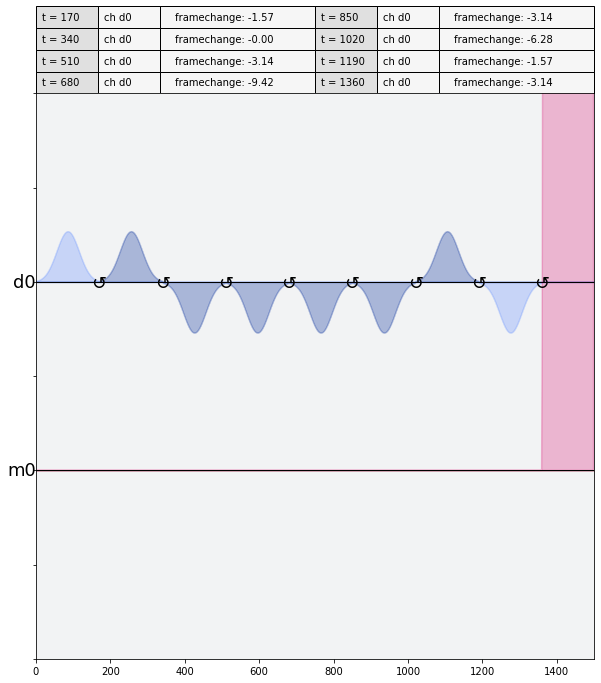

In [92]:
rb_scheds_per_seed[0][0].draw(scaling=100, channels_to_plot=[system.drives[0], system.measures[0]], plot_range=(0,1500))

## Create jobs

In [93]:
jobs = []
for i in range(len(qobj_list)):
    job = backend.run(qobj_list[i])
    jobs.append(job)

In [94]:
job_ids = []
for job in jobs:
    job_ids.append(job.job_id())
    print(job.job_id())

5d68b4efedb7530011bcd057
5d68b4f0dbca2a0012cedcfd
5d68b4f1e17db40011ea2277
5d68b4f2b03aaf00123d0f96
5d68b4f3ede9340014e7feea


In [110]:
results = []
for job in jobs:
    result = job.result(timeout=3600)
    results.append(result)

In [111]:
rbfit = rb.fitters.RBFitter(results[0], xdata, rb_opts['rb_pattern'])

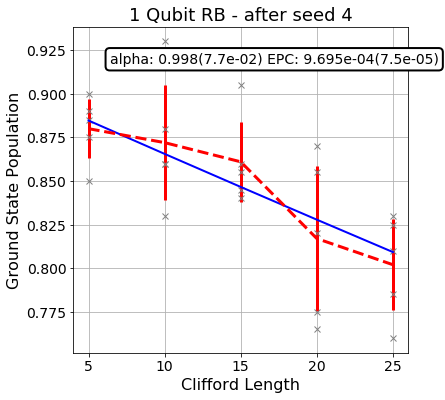

In [116]:
# Plot with all seeds

import time
rbfit = rb.fitters.RBFitter(results[0], xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(results):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1), plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)
        
    # Display
    display.display(plt.gcf())
    
    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

### Increase # of Clifford gates and run the same experiment

In [22]:
#Number of qubits
nQ = 1

#Number of seeds (random sequences)
nseeds = 5

#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,11,1)

#1Q RB on Q1
rb_pattern = [[0]]

#Do # times as many 1Q Cliffords
length_multiplier = [5]

In [23]:
nCliffs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [24]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [25]:
%%time

basis_gates = backend.configuration().basis_gates

shots = 200
rb_scheds_per_seed= []
qobj_list = []

for rb_seed, rb_circ_seed in enumerate(rb_circs):
    
    print('Compiling seed %d'%rb_seed)

    transpiled_qcs = transpile(rb_circ_seed, backend, basis_gates=basis_gates)
    
    rb_scheds = []
    for rb_length, transpiled_qc in enumerate(transpiled_qcs):
        rb_sched = pulse.Schedule(name="rb_length_%d_seed_%d" % (rb_length, rb_seed))
        rb_sched = rb_sched | schedule(transpiled_qc, backend, cmd_def=my_cmd_def)
        rb_scheds.append(rb_sched)
    
    qobj = assemble(rb_scheds, backend, meas_level=2, meas_return='single', shots=shots)
    qobj_list.append(qobj)
    
    # to visualize
    rb_scheds_per_seed.append(rb_scheds)

Compiling seed 0
Compiling seed 1
Compiling seed 2
Compiling seed 3
Compiling seed 4
CPU times: user 4.05 s, sys: 953 ms, total: 5 s
Wall time: 10.5 s


In [ ]:
jobs = []
for i in range(len(qobj_list)):
    job = backend.run(qobj_list[i])
    jobs.append(job)
    
job_ids = []
for job in jobs:
    job_ids.append(job.job_id())
    print(job.job_id())

In [27]:
results = []
for job in jobs:
    result = job.result(timeout=3600)
    results.append(result)

In [28]:
rbfit = rb.fitters.RBFitter(results[0], xdata, rb_opts['rb_pattern'])

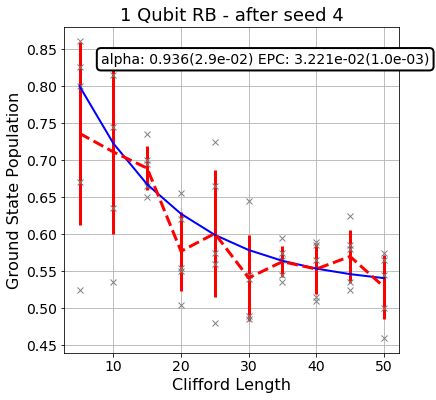

In [29]:
# Plot with all seeds

import time
rbfit = rb.fitters.RBFitter(results[0], xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(results):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1), plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)
        
    # Display
    display.display(plt.gcf())
    
    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

### Increase number of shots

In [3]:
#Number of qubits
nQ = 1

#Number of seeds (random sequences)
nseeds = 5

#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,11,1)

#1Q RB on Q1
rb_pattern = [[0]]

#Do # times as many 1Q Cliffords
length_multiplier = [5]

In [4]:
nCliffs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [5]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [ ]:
%%time

basis_gates = backend.configuration().basis_gates

shots = 400
rb_scheds_per_seed= []
qobj_list = []

for rb_seed, rb_circ_seed in enumerate(rb_circs):
    
    print('Compiling seed %d'%rb_seed)

    transpiled_qcs = transpile(rb_circ_seed, backend, basis_gates=basis_gates)
    
    rb_scheds = []
    for rb_length, transpiled_qc in enumerate(transpiled_qcs):
        rb_sched = pulse.Schedule(name="rb_length_%d_seed_%d" % (rb_length, rb_seed))
        rb_sched = rb_sched | schedule(transpiled_qc, backend, cmd_def=my_cmd_def)
        rb_scheds.append(rb_sched)
    
    qobj = assemble(rb_scheds, backend, meas_level=2, meas_return='single', shots=shots)
    qobj_list.append(qobj)
    
    # to visualize
    rb_scheds_per_seed.append(rb_scheds)

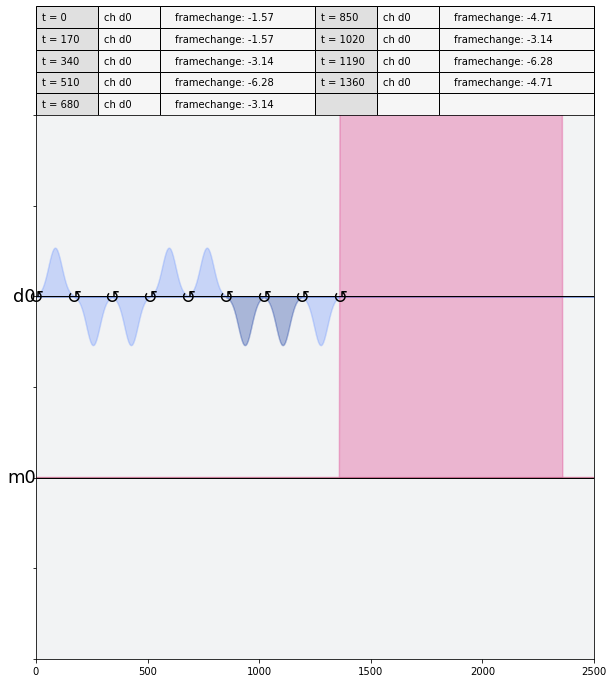

In [51]:
rb_scheds_per_seed[0][0].draw(scaling=100, channels_to_plot=[system.drives[0], system.measures[0]], plot_range=(0,2500))

In [33]:
jobs = []
for i in range(len(qobj_list)):
    job = backend.run(qobj_list[i])
    jobs.append(job)
    
job_ids = []
for job in jobs:
    job_ids.append(job.job_id())
    print(job.job_id())

5d6f1f45a022f60018990bce
5d6f1f46f248bf0018b71255
5d6f1f48720bdb0018e841ca
5d6f1f49a022f60018990bd0
5d6f1f4b61b82a0019a82ccb


In [55]:
results = []
for job in jobs:
    result = job.result(timeout=3600)
    results.append(result)

In [56]:
rbfit = rb.fitters.RBFitter(results[0], xdata, rb_opts['rb_pattern'])

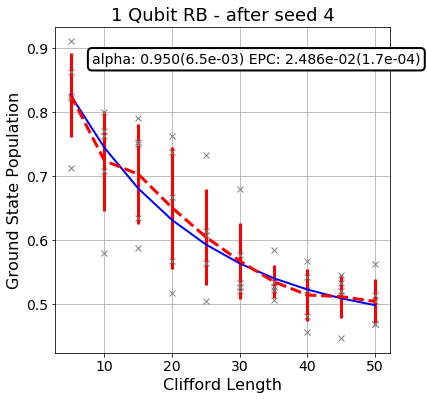

In [58]:
# Plot with all seeds

import time
rbfit = rb.fitters.RBFitter(results[0], xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(results):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1), plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)
        
    # Display
    display.display(plt.gcf())
    
    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()